## Geo-Vec Model 
- basic geo-vec model
- auxilliary task models

#### Imports:

In [14]:
import numpy as np
import pandas as pd
import scipy.sparse as ss

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#### Helper Functions

In [15]:
class Doc2Graph():
    """Convert tokenized document to weighted Adjacency matrix
    and graph Laplacian"""
    def __init__(self, doc, doc_id=-1):
        self.doc = doc
        self.doc_id = doc_id
        
    def doc2graph(self):
        g = self.load()
            
        if not g:
            As = self.get_As()
            Ls = self.get_Ls(As)
            g = As + Ls
            self.save(g)

        return g
    
    def get_As(self):
        """Get the weighted adjacency matrices of incoming
        and outcoming edges"""
        As = []
        e1 = np.vstack((self.doc[:-1], self.doc[1:])).T
        e2 = np.flip(e1, 1)
        for a in [e2, e1]:
            rc, cooc = np.unique(a, return_counts=True, axis=0)
            As.append(ss.coo_matrix((cooc, (rc[:,0], rc[:,1])), 
                                   tuple((np.max(a)+1, np.max(a)+1))))
        return As
    
    def get_Ls(self, As, renorm_trick=True):
        """Create graph Laplacians from adjacency matrices"""
        Ls = []
        for A in As:
            A = ss.coo_matrix(A)
            if renorm_trick:
                A += ss.eye(A.shape[0])
            D_inv_sqrt = ss.diags(np.power(np.array(A.sum(1)), -0.5).flatten())
            L = A.dot(D_inv_sqrt).transpose().dot(D_inv_sqrt).tocoo()
            Ls.append(L)
            
        return Ls
    
    def save(self, g):
        """Save graph to folder for reuse"""
        pass
    
    def load(self):
        return None

def sparse_to_tuple(sparse_mx):
    if not ss.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def sp2tf(sp_t, shape=None):
    t = sparse_to_tuple(sp_t)
    if shape:
        t = tuple((t[0],t[1],shape))
    tensor = tf.SparseTensorValue(t[0],t[1].astype(np.float32),t[2])
    return tensor

def tfs2sp(tfs):
    return ss.coo_matrix((tfs[1], (tfs[0][:,0], tfs[0][:,1])), tfs[2])
    
def dropout_sparse(x, keep_prob, num_nonzero_elems):
    """Dropout for sparse tensors. Currently fails for very large sparse tensors (>1M elements)
    """
    noise_shape = [num_nonzero_elems]
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)

#### Geo-Vec

In [28]:
class GeoVec():
    def __init__(self, corpus=None, vocab_size=10, h_layers = [8, 4], 
                 act = tf.nn.relu, dropout=0.0, learning_rate = 1e-3):
        """Geo-Vec model as described in the report model section."""
        
        self.corpus = corpus
        self.vocab_size = vocab_size
        self.h_layers = h_layers
        self.act = act
        self.dropout = dropout
        self.learning_rate = learning_rate
        
        # use for plotting
        self._loss_vals, self._acc_vals = [], []
        
        #placeholders
        s = [self.vocab_size, self.vocab_size]
        self.placeholders = {
            'A_o': tf.sparse_placeholder(tf.float32),
            'L_o': tf.sparse_placeholder(tf.float32),
            'A_i': tf.sparse_placeholder(tf.float32),
            'L_i': tf.sparse_placeholder(tf.float32),
            'idx_o': tf.placeholder(tf.int32),
            'idx_i': tf.placeholder(tf.int32),
            'val_o' : tf.placeholder(tf.float32),
            'val_i' : tf.placeholder(tf.float32),
            'dropout': tf.placeholder_with_default(0., shape=())
        }
        
        # model
        self.aux_losses = None
        dummy = sp2tf(ss.eye(self.vocab_size))
        self.init_model(x=dummy)

        #optimizer
        self.sample_mesh = np.mgrid[0:self.vocab_size,0:self.vocab_size].reshape(2,-1).T
        self.init_optimizer()
        
        #sess
        self.trained = 0
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def init_model(self, x, num_topics = 10, aux_tasks = None):
        """geo-vec model with variable number of gcn layers. Optional aux_taks
        param is now unimplemented to specify which tasks to add. All aux losses
        should be gathered in a self.aux_losses variable to gather later on."""
        for i, h_layer in enumerate(self.h_layers):
            if i == 0:
                h = self.gcn(x, self.vocab_size, self.h_layers[0], self.act, layer=i,sparse=True)  
            elif (i+1) < len(self.h_layers):
                h = self.gcn(h, self.h_layers[i-1], h_layer, self.act, layer=i, )
        else:
            self.emb_o, self.emb_i = self.gcn(h, self.h_layers[i-1], 
                                         h_layer, act=lambda x: x, layer=-1,separate=True)
        
        # here we can left multiply the last layer h
        # and perform auxilliary tasks.
#         w_a = tf.get_variable('w_a', shape=[num_topics, self.vocab_size], 
#                              initializer=tf.truncated_normal_initializer(0.,1e-3))
#         z_n = tf.matmul(w_a, h) ---> use for aux tasks

        self.recon_o = self.decode(self.emb_o, rbf=False)
        self.recon_i = self.decode(self.emb_i, rbf=False)
    
    def gcn(self, x, dim_in, dim_out, act, layer, sparse=False, separate=False):
        """basic graph convolution using a split up adjacency matrix.
        The separation param is to create the final embeddings to reconstruct."""
        w1 = tf.get_variable('w1_{}'.format(layer), shape=[dim_in, dim_out], 
                             initializer=tf.contrib.layers.xavier_initializer())
        w2 = tf.get_variable('w2_{}'.format(layer), shape=[dim_in, dim_out], 
                             initializer=tf.contrib.layers.xavier_initializer())
        if sparse:
            x1 = tf.sparse_tensor_dense_matmul(x, w1)
            x2 = tf.sparse_tensor_dense_matmul(x, w2)
        else:
            x1 = tf.matmul(x, w1)
            x2 = tf.matmul(x, w2)
            
        x1 = tf.sparse_tensor_dense_matmul(self.placeholders['L_o'], x1)
        x2 = tf.sparse_tensor_dense_matmul(self.placeholders['L_i'], x2)
        
        if separate:
            return self.act(x1), self.act(x2)
        
        return self.act(x1 + x2)
    
    def decode(self, x, rbf=False):
        """simple innerproduct decoder with positive activation to scale
        the edged between 0-> (assuming more co-occurances are unlikely)."""
        if rbf:
            return self.decode_RBF(x)
        x = tf.nn.dropout(x, 1-self.dropout)
        x = tf.reshape(tf.matmul(x, tf.transpose(x)), [-1])
        return tf.nn.relu(x)
      
    # not working yet, alternative to innerproduct decoder
    def decode_RBF(self, x):
        """RBF decoder"""
        dim = tf.shape(x)[0]
        x2 = tf.reshape(tf.tile(tf.square(tf.norm(x, axis=1)), [dim]), [dim, dim])
        pairwise_dist2 = x2 + tf.transpose(x2) - 2*tf.matmul(x, tf.transpose(x))
        x = tf.exp(-pairwise_dist2/(2.*(0.5**2)))
        x = tf.reshape(x, [-1])
        return tf.nn.softmax(x)
        
    def init_optimizer(self):
        """initializes optimizer and computes loss + accuracy. The loss function
        is currently a MSE, due to the fact we are dealing with weighted edges.
        This does not seem ideal, and should be thought about."""
#         labels_o = tf.reshape(tf.sparse_tensor_to_dense(
#                                 self.placeholders['A_o'], validate_indices=False), [-1])
#         labels_i = tf.reshape(tf.sparse_tensor_to_dense(
#                                 self.placeholders['A_i'], validate_indices=False), [-1])
#         loss_o = tf.losses.mean_squared_error(self.recon_o, labels_o, 
#                                               weights = self.get_weights(labels_o))
#         loss_i = tf.losses.mean_squared_error(self.recon_i, labels_i, 
#                                               weights = self.get_weights(labels_i)) 
#         self.loss = loss_o + loss_i
        
        emb_or = tf.gather(self.emb_o, self.placeholders['idx_o'][:, 0])
        emb_oc = tf.gather(self.emb_o, self.placeholders['idx_o'][:, 1])
        emb_ir = tf.gather(self.emb_i, self.placeholders['idx_i'][:, 0])
        emb_ic = tf.gather(self.emb_i, self.placeholders['idx_i'][:, 1])
        
        pred_o = tf.reduce_sum(tf.multiply(emb_or, emb_oc), 1)
        pred_i = tf.reduce_sum(tf.multiply(emb_ir, emb_ic), 1)
        
        loss_o = tf.losses.mean_squared_error(pred_o, self.placeholders['val_o'])
        loss_i = tf.losses.mean_squared_error(pred_i, self.placeholders['val_i']) 
        self.loss = loss_o + loss_i
        
        # gather aux losses and add to total loss
        if self.aux_losses:
            self.loss += self.aux_losses
        
        # optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.opt_op = optimizer.minimize(self.loss)

        # accuracy
        cp_o = tf.equal(tf.cast(pred_o, tf.int32), tf.cast(self.placeholders['val_o'], tf.int32))
        cp_i = tf.equal(tf.cast(pred_i, tf.int32), tf.cast(self.placeholders['val_i'], tf.int32))
        correct_prediction = tf.concat([cp_o, cp_i], 0)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
#     def get_weights(self, labels):
#         """Compute positive and negative example weights"""
#         pos_sum = tf.reduce_sum(labels)
#         pos_weight = (self.vocab_size**2 - pos_sum) / pos_sum
#         thresh = tf.fill(tf.shape(labels), 1.)
#         x = tf.fill(tf.shape(labels), 0.001)
#         y = tf.fill(tf.shape(labels), pos_weight)
#         return tf.where(tf.less(labels, thresh), x, y)
    
    def get_feed_dict(self, A_o, A_i, L_o, L_i, idx_o, idx_i, val_i, val_o):
        feed_dict = {self.placeholders['A_o']: A_o,
                     self.placeholders['A_i']: A_i,
                     self.placeholders['L_o']: L_o,
                     self.placeholders['L_i']: L_i,
                     self.placeholders['idx_o'] : idx_o,
                     self.placeholders['idx_i'] : idx_i,
                     self.placeholders['val_o'] : val_o,
                     self.placeholders['val_i'] : val_i}
        return feed_dict
    
    def get_sample(self, batch_size=64, ratio=1.):
        """get random sample from corpus graph cache"""
        dummy = Doc2Graph(fake_doc).doc2graph()
        
        # sample positive examples
        pos_idx_o = np.random.choice(range(len(dummy[0].row)), batch_size)
        pos_idx_i = np.random.choice(range(len(dummy[1].row)), batch_size)
        idx_o = np.array(list(zip(dummy[0].row, dummy[0].col)))[pos_idx_o, :]
        idx_i = np.array(list(zip(dummy[1].row, dummy[1].col)))[pos_idx_i, :]
        
        val_o = dummy[0].data[pos_idx_o]
        val_i = dummy[1].data[pos_idx_i]
        
        # separately generate negative samples
        neg_o = np.random.randint(self.vocab_size, size=[int(batch_size*ratio), 2])
        neg_i = np.random.randint(self.vocab_size, size=[int(batch_size*ratio), 2])
        
        # concat
        val_o = np.hstack((val_o, np.zeros(int(batch_size*ratio))))
        val_i = np.hstack((val_i, np.zeros(int(batch_size*ratio))))
        idx_o = np.vstack((idx_o, neg_o))
        idx_i = np.vstack((idx_i, neg_i))
        
        for i, d in enumerate(dummy):
            dummy[i] = sp2tf(d, tuple((self.vocab_size, self.vocab_size)))
        return dummy, idx_o, idx_i, val_o, val_i
    
    def train(self, num_epochs = 100, print_freq=50):
        """train op that can be invoked multiple times."""
        tf.set_random_seed(42)
        np.random.seed(42)

        for e in range(num_epochs):
            self.trained += 1
            (A_o, A_i, L_o, L_i), idx_o, idx_i, val_o, val_i = self.get_sample()
            feed_dict = self.get_feed_dict(A_o, A_i, L_o, L_i, idx_o, idx_i, val_o, val_i)
    
            outs = self.sess.run([self.opt_op, self.loss, self.accuracy], feed_dict=feed_dict)
            avg_loss, avg_acc = outs[1], outs[2]
            self._loss_vals.append(avg_loss)
            self._acc_vals.append(avg_acc)
            
            print('\r epoch: %d/%d \t loss: %.3f \t avg_acc: %.3f' 
                      % (e+1, num_epochs, avg_loss, avg_acc), end='')
            if (e + 1) % print_freq == 0:
                print('')
        else:
            print('----> done training: {} epochs'.format(self.trained))
        
    def plot(self):
        """Plotting loss function"""
        plt.figure(figsize=(12, 6))
        plt.plot(self._loss_vals, color='red')
        plt.plot(self._acc_vals, color='blue')
        
        plt.legend(handles=[mpatches.Patch(color='red', label='loss'),
                            mpatches.Patch(color='blue', label='acc')],
                   bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        
    def get_reconstruction(self, doc = None):
        if doc:
            A_o, A_i, L_o, L_i = Doc2Graph(doc, doc_id).doc2graph()
        else:
            (A_o, A_i, L_o, L_i), idx_o, idx_i, val_o, val_i = self.get_sample()
            
        feed_dict = self.get_feed_dict(A_o, A_i, L_o, L_i, idx_o, idx_i, val_o, val_i)
        recon_o, recon_i = self.sess.run([self.recon_o, self.recon_i], feed_dict=feed_dict)
        return A_o, A_i, recon_o, recon_i
    
    def get_embeddings(self, doc = None, doc_id = None):
        if doc:
            A_o, A_i, L_o, L_i = Doc2Graph(doc, doc_id).doc2graph()
        else:
            A_o, A_i, L_o, L_i = self.get_sample()
            
        feed_dict = self.get_feed_dict(A_o, A_i, L_o, L_i)
        emb_o, emb_i = self.sess.run([self.em_o, self.emb_i], feed_dict=feed_dict)
        return A_o, A_i, emb_o, emb_i

In [44]:
tf.reset_default_graph()
fake_doc = np.asarray([1, 0, 1, 2, 1, 4])
geo_vec_model = GeoVec(vocab_size=5, h_layers = [4,2], learning_rate = 1e-4)
geo_vec_model.get_sample()
geo_vec_model.train(2500, 300)

//anaconda/envs/pytorch3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 epoch: 300/2500 	 loss: 1.572 	 avg_acc: 0.000
 epoch: 600/2500 	 loss: 1.390 	 avg_acc: 0.000
 epoch: 900/2500 	 loss: 1.179 	 avg_acc: 0.000
 epoch: 1200/2500 	 loss: 0.977 	 avg_acc: 0.078
 epoch: 1500/2500 	 loss: 0.778 	 avg_acc: 0.102
 epoch: 1800/2500 	 loss: 0.531 	 avg_acc: 0.070
 epoch: 2100/2500 	 loss: 0.344 	 avg_acc: 0.109
 epoch: 2400/2500 	 loss: 0.161 	 avg_acc: 0.094
 epoch: 2500/2500 	 loss: 0.135 	 avg_acc: 0.141----> done training: 2500 epochs


 epoch: 300/2500 	 loss: 0.058 	 avg_acc: 0.055
 epoch: 600/2500 	 loss: 0.036 	 avg_acc: 0.344
 epoch: 900/2500 	 loss: 0.031 	 avg_acc: 0.328
 epoch: 1200/2500 	 loss: 0.025 	 avg_acc: 0.320
 epoch: 1500/2500 	 loss: 0.022 	 avg_acc: 0.297
 epoch: 1800/2500 	 loss: 0.018 	 avg_acc: 0.477
 epoch: 2100/2500 	 loss: 0.014 	 avg_acc: 0.547
 epoch: 2400/2500 	 loss: 0.012 	 avg_acc: 0.531
 epoch: 2500/2500 	 loss: 0.011 	 avg_acc: 0.578----> done training: 5000 epochs


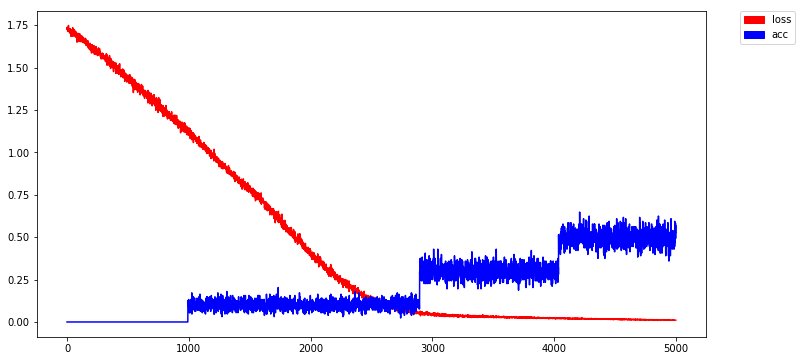

In [45]:
geo_vec_model.train(2500, 300)
geo_vec_model.plot()

In [46]:
a1, a2, r1, r2 = geo_vec_model.get_reconstruction()

In [56]:
tfs2sp(a1).A

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.]], dtype=float32)

In [57]:
np.reshape(r1, (geo_vec_model.vocab_size,-1)) -ss.eye(5)

matrix([[-0.39296556,  1.0933392 ,  0.51950735,  0.        ,  0.53166515],
        [ 1.0933392 ,  0.96923029,  0.93569285,  0.        ,  0.9575904 ],
        [ 0.51950735,  0.93569285, -0.55539936,  0.        ,  0.45500544],
        [ 0.        ,  0.        ,  0.        , -1.        ,  0.        ],
        [ 0.53166515,  0.9575904 ,  0.45500544,  0.        , -0.53434628]])

In [ ]:
sess = tf.InteractiveSession()
sp = tf.sparse_slice(a1,[0,1], [1,1])
print(sp.eval())
sess.close()
sp.values

In [ ]:
t = 1.0 / tf.constant([[1., 1., 1., 1., 1.],
                 [1., 1., 1., 1., 1.],
                 [1., 1., 1., 1., 1.],
                 [1., 1., 1., 1., 1.],
                 [1., 1., 1., 1., 1.]])
sp.__div__(t)

In [ ]:
aa, a2, l1, l2 = Doc2Graph(fake_doc).doc2graph()

In [ ]:
a1.indices

In [ ]:
pos_idx = a1.indices[np.random.choice(np.arange(np.shape(a1)[0]), size=[]) ]

In [ ]:
pos_idx = a1.indices[np.random.randint(np.shape(a1.indices)[0], size=[4,1])].squeeze()
neg_idx = np.random.randint(10, size=[4,1])

In [ ]:
pos_idx

In [ ]:
a = np.array([1,2,3])
b = np.array([1, 2])
np.vstack(np.meshgrid(a, a)).reshape(2, -1).T

In [11]:
c = np.array([[1, 2, 3],[1, 1, 1],[1, 2, 3]])
ss = np.array([[1,0],[1,1]])
c1 = c[ss[:,0]]
c2 = c[ss[:,1]]
print(c)
np.mean(np.multiply(c1, c2), axis=1).T

[[1 2 3]
 [1 1 1]
 [1 2 3]]


array([ 2.,  1.])